# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

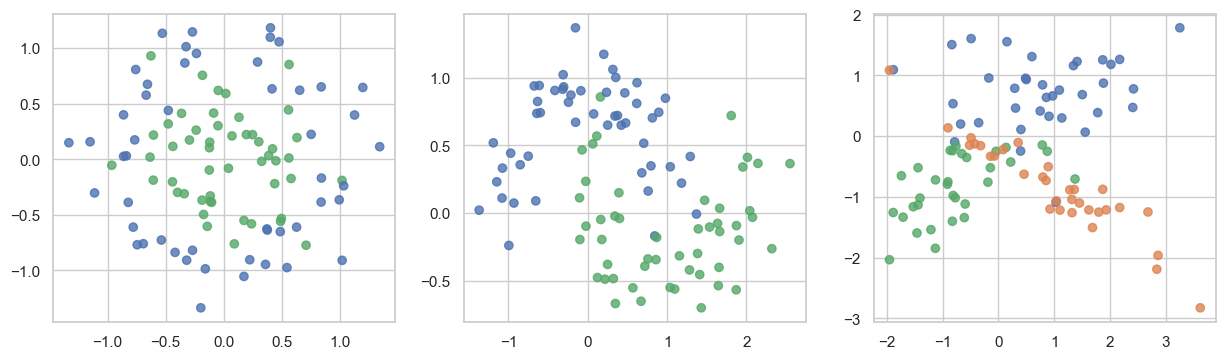

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

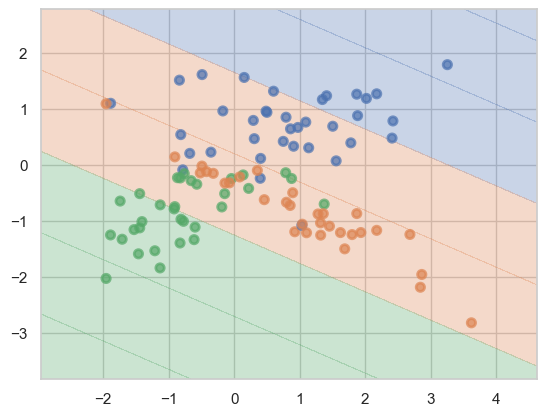

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)


================ Dataset 0 ================
Train accuracy: 1.0000
Test accuracy:  0.7333
Дерево переобучилось.


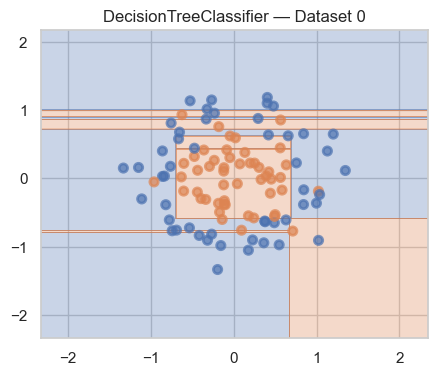


================ Dataset 1 ================
Train accuracy: 1.0000
Test accuracy:  0.8667
Дерево переобучилось.


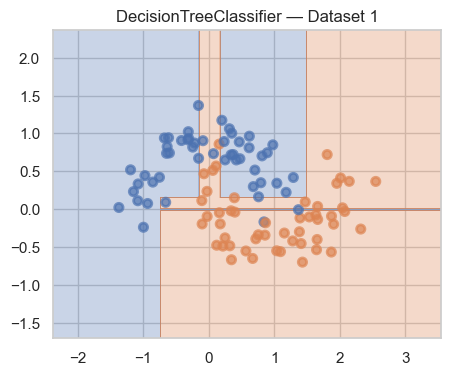


================ Dataset 2 ================
Train accuracy: 1.0000
Test accuracy:  0.8333
Дерево переобучилось.


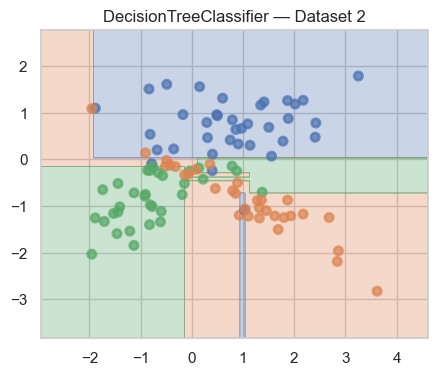

In [7]:
for i, (X, y) in enumerate(datasets):
    print(f"\n================ Dataset {i} ================")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)

    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test accuracy:  {test_acc:.4f}")

    if train_acc > 0.98 and test_acc < train_acc - 0.1:
        print("Дерево переобучилось.")
    else:
        print("Переобучение отсутствует.")

    plt.figure(figsize=(5, 4))
    plot_surface(clf, X, y)
    plt.title(f"DecisionTreeClassifier — Dataset {i}")
    plt.show()

__Ответ:__ разница между train accuracy и test accuracy большая - дееревья со стандартными параметрами переобучились.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


================ Dataset 0 ================

max_depth=None, min_samples_leaf=1 --> train_acc=1.000, test_acc=0.733
max_depth=None, min_samples_leaf=3 --> train_acc=0.943, test_acc=0.733
max_depth=None, min_samples_leaf=5 --> train_acc=0.871, test_acc=0.900
max_depth=3, min_samples_leaf=1 --> train_acc=0.886, test_acc=0.733
max_depth=3, min_samples_leaf=3 --> train_acc=0.886, test_acc=0.700
max_depth=3, min_samples_leaf=5 --> train_acc=0.857, test_acc=0.800
max_depth=5, min_samples_leaf=1 --> train_acc=0.971, test_acc=0.767
max_depth=5, min_samples_leaf=3 --> train_acc=0.943, test_acc=0.733
max_depth=5, min_samples_leaf=5 --> train_acc=0.871, test_acc=0.900
max_depth=8, min_samples_leaf=1 --> train_acc=1.000, test_acc=0.733
max_depth=8, min_samples_leaf=3 --> train_acc=0.943, test_acc=0.733
max_depth=8, min_samples_leaf=5 --> train_acc=0.871, test_acc=0.900


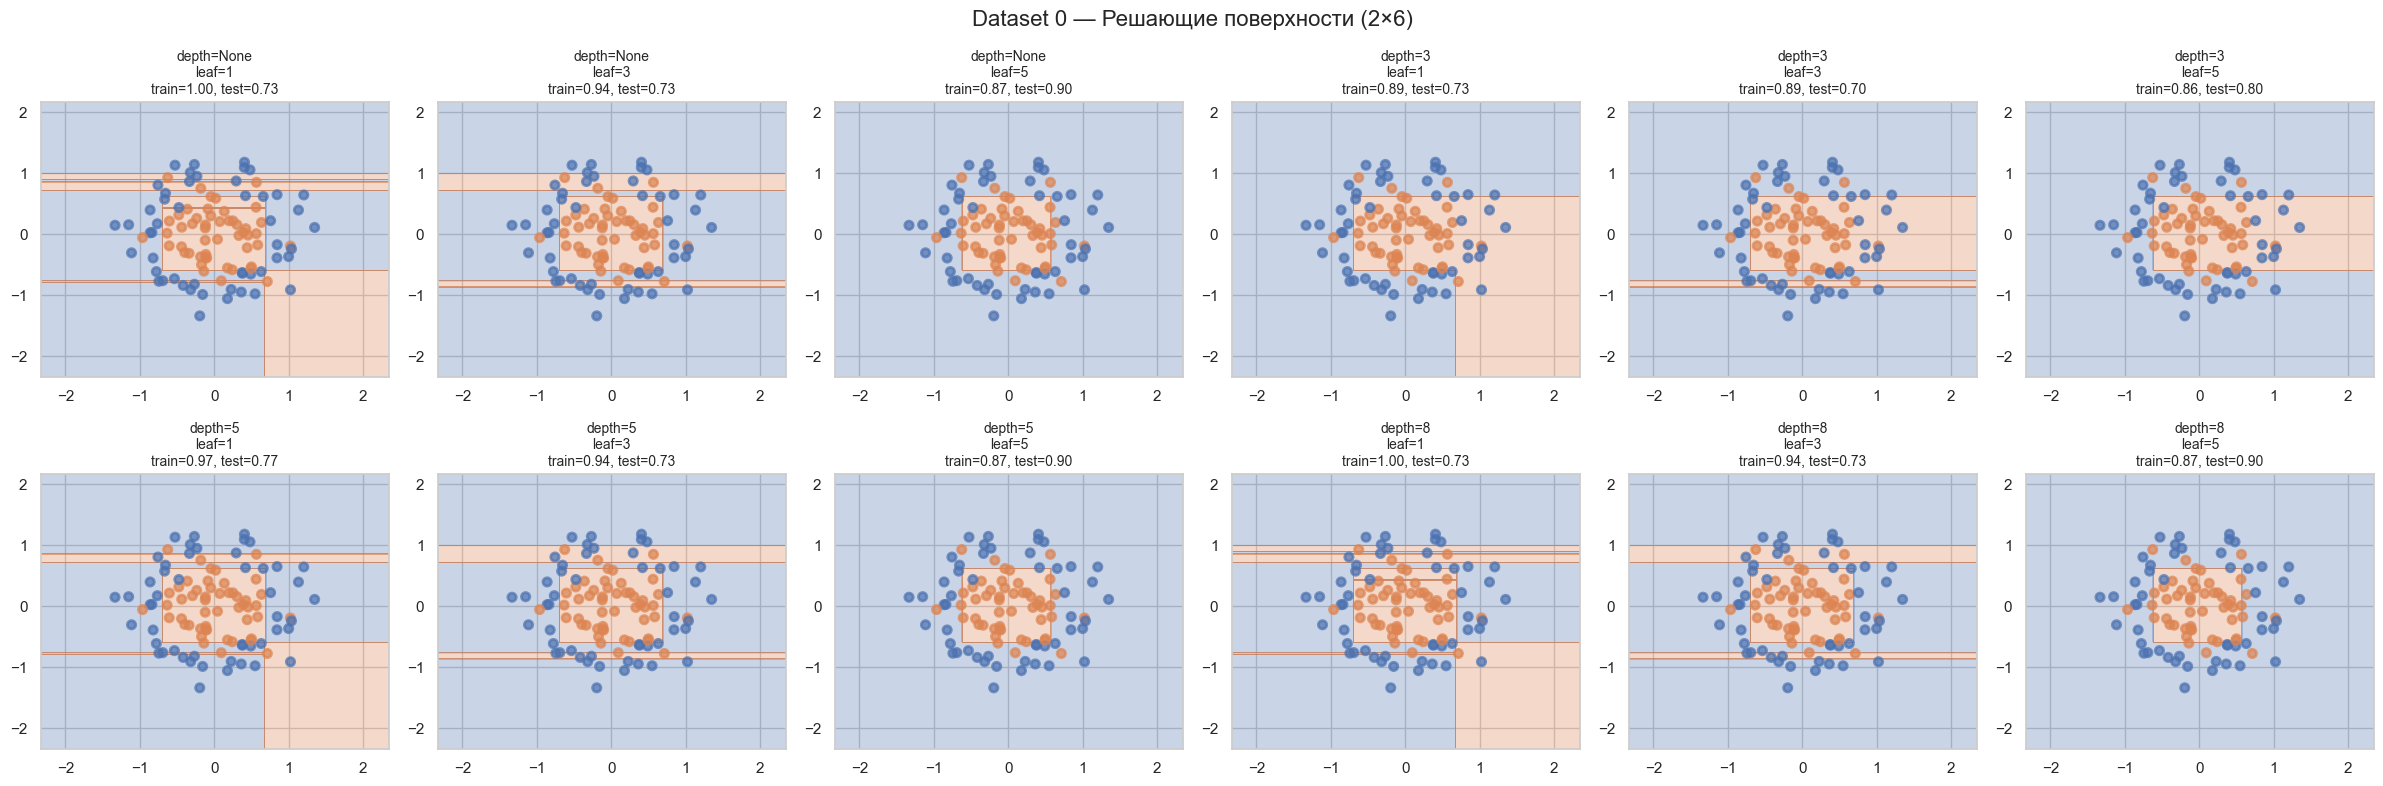


================ Dataset 1 ================

max_depth=None, min_samples_leaf=1 --> train_acc=1.000, test_acc=0.867
max_depth=None, min_samples_leaf=3 --> train_acc=0.986, test_acc=0.767
max_depth=None, min_samples_leaf=5 --> train_acc=0.957, test_acc=0.733
max_depth=3, min_samples_leaf=1 --> train_acc=0.914, test_acc=0.933
max_depth=3, min_samples_leaf=3 --> train_acc=0.914, test_acc=0.833
max_depth=3, min_samples_leaf=5 --> train_acc=0.886, test_acc=0.800
max_depth=5, min_samples_leaf=1 --> train_acc=1.000, test_acc=0.867
max_depth=5, min_samples_leaf=3 --> train_acc=0.986, test_acc=0.767
max_depth=5, min_samples_leaf=5 --> train_acc=0.957, test_acc=0.733
max_depth=8, min_samples_leaf=1 --> train_acc=1.000, test_acc=0.867
max_depth=8, min_samples_leaf=3 --> train_acc=0.986, test_acc=0.767
max_depth=8, min_samples_leaf=5 --> train_acc=0.957, test_acc=0.733


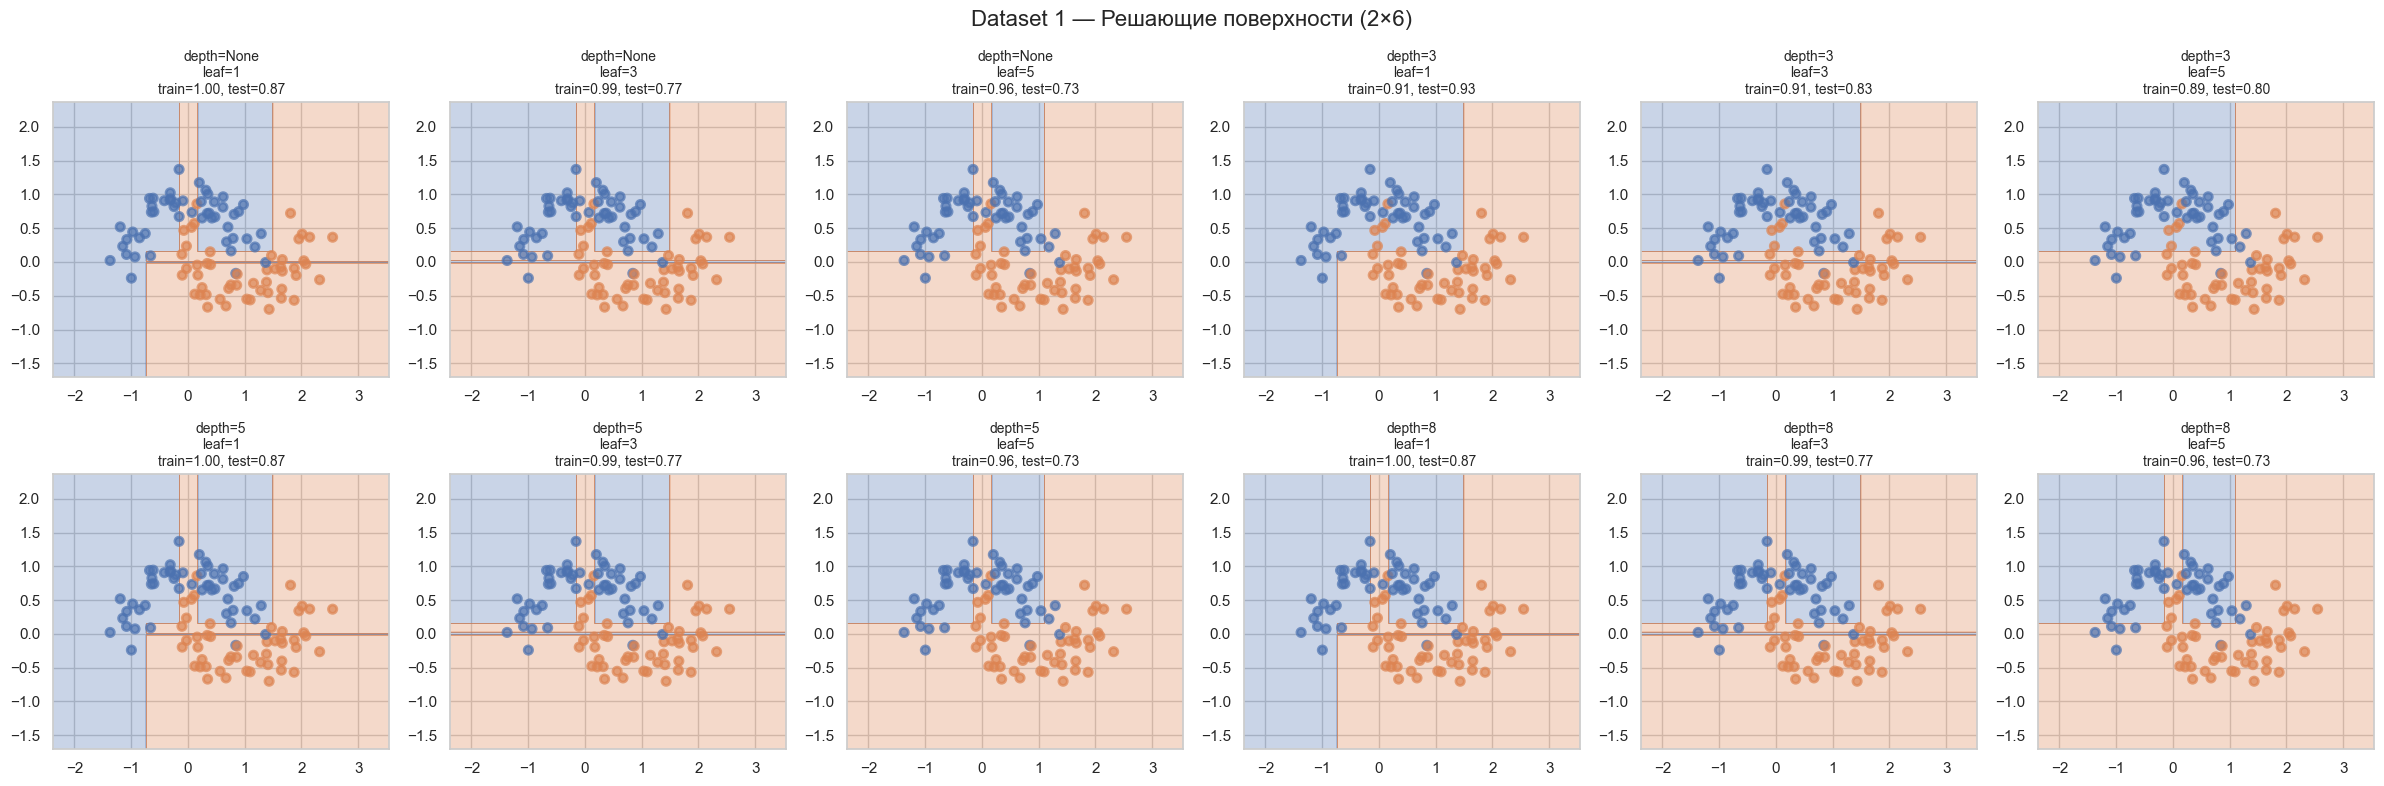


================ Dataset 2 ================

max_depth=None, min_samples_leaf=1 --> train_acc=1.000, test_acc=0.833
max_depth=None, min_samples_leaf=3 --> train_acc=0.914, test_acc=0.767
max_depth=None, min_samples_leaf=5 --> train_acc=0.900, test_acc=0.700
max_depth=3, min_samples_leaf=1 --> train_acc=0.943, test_acc=0.867
max_depth=3, min_samples_leaf=3 --> train_acc=0.914, test_acc=0.767
max_depth=3, min_samples_leaf=5 --> train_acc=0.886, test_acc=0.767
max_depth=5, min_samples_leaf=1 --> train_acc=0.971, test_acc=0.800
max_depth=5, min_samples_leaf=3 --> train_acc=0.914, test_acc=0.767
max_depth=5, min_samples_leaf=5 --> train_acc=0.900, test_acc=0.700
max_depth=8, min_samples_leaf=1 --> train_acc=1.000, test_acc=0.833
max_depth=8, min_samples_leaf=3 --> train_acc=0.914, test_acc=0.767
max_depth=8, min_samples_leaf=5 --> train_acc=0.900, test_acc=0.700


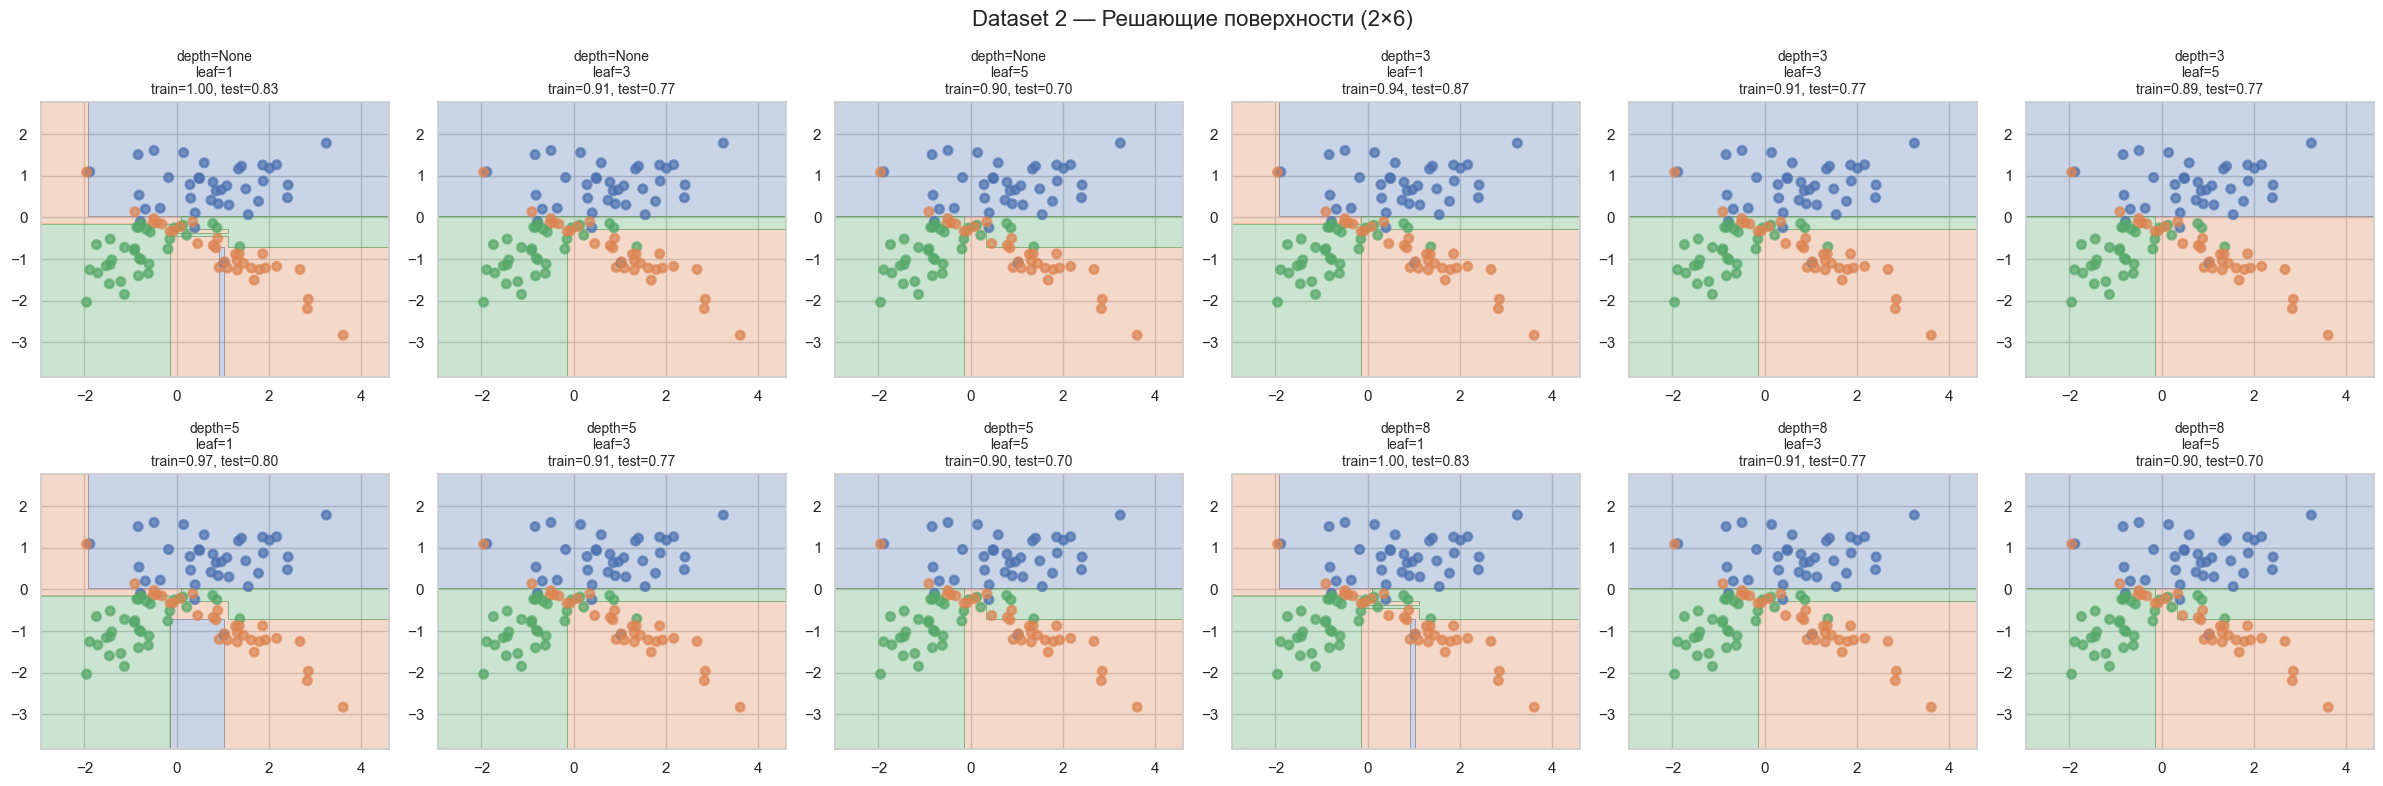

In [8]:
def plot_surface(clf, X, y, ax):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step),
        np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.7,
        edgecolors=np.array(palette)[y], linewidths=2
    )

max_depth_list = [None, 3, 5, 8]
min_samples_leaf_list = [1, 3, 5]
params = [(d, l) for d in max_depth_list for l in min_samples_leaf_list]

for d, (X, y) in enumerate(datasets):
    print(f"\n================ Dataset {d} ================\n")

    # фиксированное разбиение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    fig, axes = plt.subplots(2, 6, figsize=(24, 8))
    axes = axes.ravel()

    for idx, (depth, leaf) in enumerate(params):
        ax = axes[idx]

        clf = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=42
        )
        clf.fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)

        print(f"max_depth={depth}, min_samples_leaf={leaf} --> "
              f"train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")

        plot_surface(clf, X, y, ax)

        ax.set_title(f"depth={depth}\nleaf={leaf}\n"
                     f"train={train_acc:.2f}, test={test_acc:.2f}",
                     fontsize=10)

    fig.suptitle(f"Dataset {d} — Решающие поверхности (2×6)", fontsize=16)
    plt.tight_layout()
    plt.show()

__Ответ:__ При больших значениях глубины дерева и малых значениях min_samples_leaf разделяющая поверхность становится сильно рваной, так как дерево подстраивается под шум и отдельные точки, что приводит к переобучению: train accuracy близка к 1, а test accuracy заметно ниже. При увеличении min_samples_leaf или уменьшении max_depth поверхность сглаживается, дерево делает более крупные разбиения и лучше обобщает, что видно по росту test accuracy и снижению разрыва между train и test качеством. На простых датасетах неглубокие деревья дают хорошие результаты. Тяжелые сильнее чувствительны к изменению гиперпараметров. В целом эффект регуляризации одинаковый — поверхности становятся проще, а обобщающая способность растёт

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

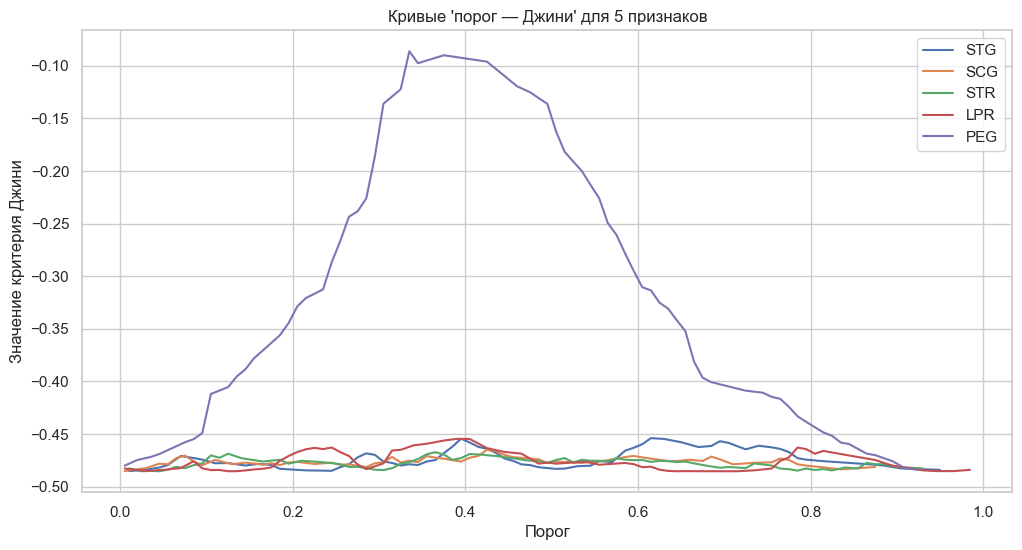

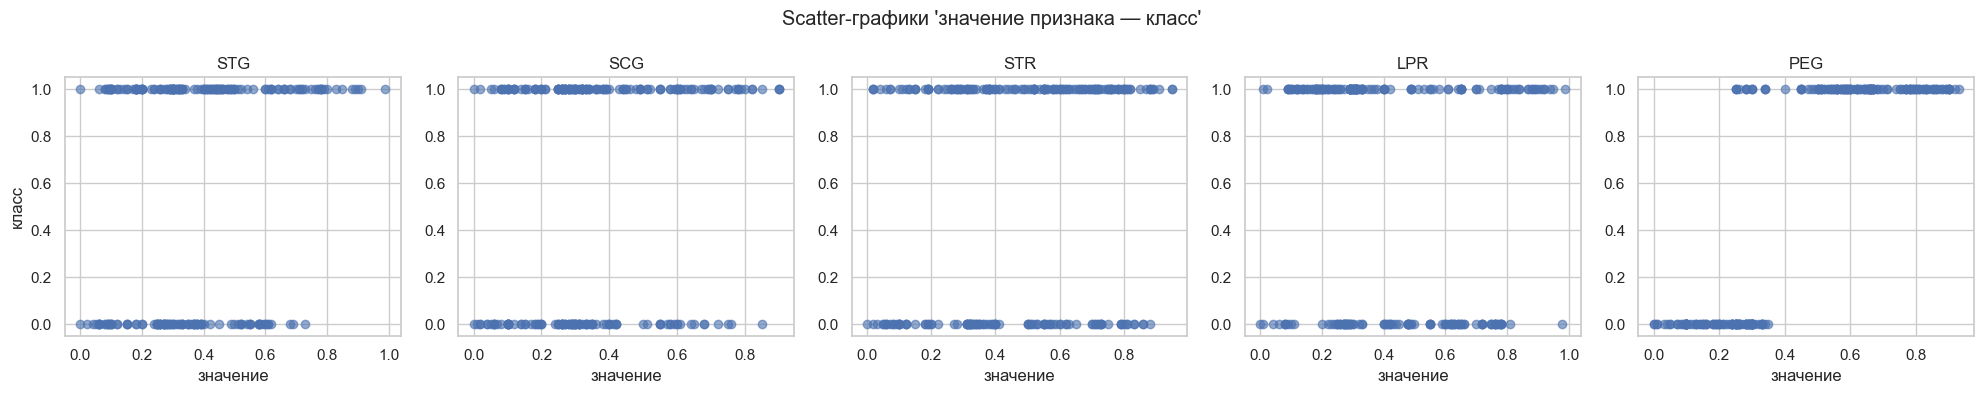

In [9]:
from hw2code import find_best_split   # импорт твоей функции

df = pd.read_csv("data/datasets/students.csv")

feature_names = df.columns[:-1]
X = df[feature_names].values
y = df["UNS"].values

plt.figure(figsize=(12, 6))

for i, fname in enumerate(feature_names):
    thresholds, ginis, _, _ = find_best_split(X[:, i], y)
    plt.plot(thresholds, ginis, label=fname)

plt.xlabel("Порог")
plt.ylabel("Значение критерия Джини")
plt.title("Кривые 'порог — Джини' для 5 признаков")
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, fname in enumerate(feature_names):
    axes[i].scatter(X[:, i], y, alpha=0.6)
    axes[i].set_title(fname)
    axes[i].set_xlabel("значение")
    if i == 0:
        axes[i].set_ylabel("класс")

plt.suptitle("Scatter-графики 'значение признака — класс'")
plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Деление выборки надо производить по признаку PEG - его кривая значений критерия Джини значительно выделяется, в то время как остальные кривые почти плоские и не показывают выраженную зависимость от порога. Результат согласуется с визуальной оценкой scatter-графиков, так как scatter-график для PEG почти не имеет перемешивания классов по области значений.
Для хороших признаков кривая Джини имеет или выраженный пик, или глубокий минимум и заметно меняется при изменении порога. Для плохих признаков кривая почти плоская

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/datasets/agaricus-lepiota.data", header=None)

print("Shape:", df.shape)

encoders = []
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders.append(le)

y = df[0].values
X = df.drop(columns=[0]).values

feature_types = ["categorical"] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, shuffle=True
)

from hw2code import DecisionTree

tree = DecisionTree(
    feature_types=feature_types,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Shape: (8124, 23)
Accuracy: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [car](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from hw2code import DecisionTree

accuracy = make_scorer(accuracy_score)

datasets_dict = {}

data_mush = pd.read_csv('data/datasets/agaricus-lepiota.data', header=None)
X_mush = data_mush.iloc[:, 1:].values
y_mush = LabelEncoder().fit_transform(data_mush.iloc[:, 0].values)

for i in range(X_mush.shape[1]):
    X_mush[:, i] = LabelEncoder().fit_transform(X_mush[:, i])

datasets_dict['mushrooms'] = (X_mush, y_mush)

data_ttt = pd.read_csv('data/datasets/tic-tac-toe-endgame.csv', header=None)
X_ttt = data_ttt.iloc[:, :-1].values
y_ttt = LabelEncoder().fit_transform(data_ttt.iloc[:, -1].values)

for i in range(X_ttt.shape[1]):
    X_ttt[:, i] = LabelEncoder().fit_transform(X_ttt[:, i])

datasets_dict['tic-tac-toe'] = (X_ttt, y_ttt)

data_cars = pd.read_csv('data/datasets/car.data', header=None)
X_cars = data_cars.iloc[:, :-1].values
y_cars_raw = data_cars.iloc[:, -1].values

# Классы → 0/1
y_cars = pd.Series(y_cars_raw).replace({
    "unacc": 0, "acc": 0,
    "good": 1, "vgood": 1
}).values

for i in range(X_cars.shape[1]):
    X_cars[:, i] = LabelEncoder().fit_transform(X_cars[:, i])

datasets_dict['cars'] = (X_cars, y_cars)


data_nur = pd.read_csv('data/datasets/nursery.data', header=None)
X_nur = data_nur.iloc[:, :-1].values
y_nur_raw = data_nur.iloc[:, -1].values

y_nur = pd.Series(y_nur_raw).replace({
    "not_recom": 0, "recommend": 0,
    "very_recom": 1, "priority": 1, "spec_prior": 1
}).values

for i in range(X_nur.shape[1]):
    X_nur[:, i] = LabelEncoder().fit_transform(X_nur[:, i])

datasets_dict['nursery'] = (X_nur, y_nur)


def test_algorithms(X, y):
    results = {}

    # --- 1. DecisionTree (все признаки вещественные) ---
    tree_real = DecisionTree(['real'] * X.shape[1])
    scores = cross_val_score(tree_real, X, y, cv=10, scoring=accuracy)
    results['DT_real'] = scores.mean()

    # --- 2. DecisionTree (все признаки категориальные) ---
    tree_cat = DecisionTree(['categorical'] * X.shape[1])
    scores = cross_val_score(tree_cat, X, y, cv=10, scoring=accuracy)
    results['DT_categorical'] = scores.mean()

    # --- 3. DecisionTree + OneHotEncoder ---
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X)
    tree_ohe = DecisionTree(['real'] * X_ohe.shape[1])
    scores = cross_val_score(tree_ohe, X_ohe, y, cv=10, scoring=accuracy)
    results['DT_real_OHE'] = scores.mean()

    # --- 4. sklearn DecisionTreeClassifier ---
    clf = DecisionTreeClassifier(random_state=42)
    scores = cross_val_score(clf, X, y, cv=10, scoring=accuracy)
    results['sklearn_DT'] = scores.mean()

    return results

results_df = pd.DataFrame()

for name, (X, y) in datasets_dict.items():
    print(f"Тестирование {name}...")
    results = test_algorithms(X, y)
    results_df = pd.concat([results_df, pd.DataFrame([results], index=[name])])

print("\nРезультаты:")
print(results_df)


Тестирование mushrooms...
Тестирование tic-tac-toe...
Тестирование cars...
Тестирование nursery...

Результаты:
              DT_real  DT_categorical  DT_real_OHE  sklearn_DT
mushrooms    0.999261        1.000000     0.999631    0.960384
tic-tac-toe  0.084583        0.117018     0.095011    0.785351
cars         0.942647        0.967546     0.919495    0.942707
nursery      0.999691        0.999846     0.999537    0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Результаты показывают, что эффективность алгоритмов сильно зависит от структуры и характера данных. Для наборов mushrooms и nursery все реализации дерева, включая собственные версии с вещественными или категориальными признаками, достигают почти идеальной точности, что объясняется простотой и высокой информативностью признаков для разделения классов. В случае cars лучший результат показало дерево с категоризацией признаков, что связано с тем, что исходные признаки являются категориальными и их правильное кодирование позволяет лучше выявлять закономерности. Для tic-tac-toe наблюдается низкая точность собственных деревьев, особенно при интерпретации признаков как вещественных, что связано с тем, что все признаки категориальные и имеют бинарные значения; sklearn-реализация показывает лучший результат благодаря оптимизациям и эвристикам для категориальных данных. Влияние случайности проявляется в кросс-валидации и случайной перестановке данных, а также в возможной случайной инициализации дерева sklearn; уменьшить ее можно, задавая фиксированный random_state и обеспечивая одинаковое кодирование и порядок данных, что позволяет стабилизировать качество алгоритмов и повысить reproducibility эксперимента.

Вставьте что угодно, описывающее ваши впечатления от этого задания: